## Kaggle – DataTops®
Tu profe ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a tu profe a mejorar ese modelo?

## Métrica: 
El error cuadrático medio (RMSE, por sus siglas en inglés) es una medida de la desviación estándar de los residuos (errores de predicción). Los residuos representan la diferencia entre los valores observados y los valores predichos por el modelo. El RMSE indica qué tan dispersos están estos errores: cuanto menor es el RMSE, más cercanas están las predicciones a los valores reales. En otras palabras, el RMSE mide qué tan bien se ajusta la línea de regresión a los datos.


$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$


## 1. Librerías

In [2]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

## 2. Datos

In [3]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df = pd.read_csv("./data/train.csv", index_col = "laptop_ID")
df.name = None


### 2.1 Exploración de los datos

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


In [5]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
laptop_ID,,,,,,,,,,,,
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


In [6]:
df.tail()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
laptop_ID,,,,,,,,,,,,
28,Dell,Inspiron 5570,Notebook,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,AMD Radeon 530,Windows 10,2.2kg,800.00
1160,HP,Spectre Pro,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.48kg,1629.00
78,Lenovo,IdeaPad 320-15IKBN,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,2TB HDD,Intel HD Graphics 620,No OS,2.2kg,519.00
23,HP,255 G6,Notebook,15.6,1366x768,AMD E-Series E2-9000e 1.5GHz,4GB,500GB HDD,AMD Radeon R2,No OS,1.86kg,258.00
229,Dell,Alienware 17,Gaming,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows 10,4.42kg,2456.34


In [7]:
df.describe()

,Inches,Price_in_euros
count,912.000000,912.000000
mean,14.981579,1111.724090
std,1.436719,687.959172
min,10.100000,174.000000
25%,14.000000,589.000000
50%,15.600000,978.000000
75%,15.600000,1483.942500
max,18.400000,6099.000000


In [8]:
def cardinalidad(df_in, umbral_categoria, umbral_countinua):
    '''
    Esta función obtiene la cardinalidad de cada una de las variables y en función de dicha cardinalidad sugiere un tipo de variable.
    Los tipos posibles son: binaria, categórica, numérica discreta y numérica continua.
    Nota: los tipos mostrados en el DataFrame que retorna la función son solo una sugerencia, es mejor guardar el DataFrame en una variable y modificar los tipos si es necesario.

    
    Argumentos:
    
    df_in (pd.DataFrame): dataset en formato DataFrame para clasificar sus variables.

    umbral_categoría (int): número máximo de valores únicos para clasificar una variable como categórica.

    umbral_continua (int): porcentaje mínimo de valores únicos que debe tener una variable para clasificarla como numérica continua.

    
    Retorna:

    pd.DataFrame: DataFrame con 4 columnas: nombre de la variable, cardinalidad, porcentaje de valores únicos y tipo sugerido
    '''


    cardinalidad = [df_in[col].nunique() for col in df_in.columns]
    cardinalidad_por = [df_in[col].nunique()/len(df_in[col]) for col in df_in.columns]
    dict_df = {"nombre_variable": df_in.columns, "valores_unicos": cardinalidad, "cardinalidad": cardinalidad_por}
    nuevo_df = pd.DataFrame(dict_df)
    nuevo_df["tipo_sugerido"] = "Categórica"
    nuevo_df.loc[nuevo_df["valores_unicos"] == 2, "tipo_sugerido"] = "Binaria"
    nuevo_df.loc[nuevo_df["valores_unicos"] >= umbral_categoria, "tipo_sugerido"] = "Numerica Discreta"
    nuevo_df.loc[nuevo_df["cardinalidad"] >= umbral_countinua, "tipo_sugerido"] = "Numerica Continua"
    return nuevo_df

In [9]:
cardinalidad(df, 19, 0.3)

,nombre_variable,valores_unicos,cardinalidad,tipo_sugerido
0,Company,19,0.020833,Numerica Discreta
1,Product,480,0.526316,Numerica Continua
2,TypeName,6,0.006579,Categórica
3,Inches,17,0.018640,Categórica
4,ScreenResolution,36,0.039474,Numerica Discreta
5,Cpu,107,0.117325,Numerica Discreta
6,Ram,9,0.009868,Categórica
7,Memory,37,0.040570,Numerica Discreta
8,Gpu,93,0.101974,Numerica Discreta
9,OpSys,9,0.009868,Categórica


##  Procesado de datos

Nuestro target es la columna `Price_in_euros`

In [10]:
target = "Price_in_euros"

In [11]:
df["Ram"].value_counts()

Ram
8GB     434
4GB     267
16GB    136
6GB      24
2GB      20
12GB     19
32GB     10
64GB      1
24GB      1
Name: count, dtype: int64

In [12]:
#Tratando columnas y datos
def feature_engineering(data, is_training=True):
    """
    Apply feature engineering to the dataset
    """
    data = data.copy()
    
    # RAM processing
    data["Ram_GB"] = data["Ram"].str.replace("GB", "").astype(float)
    
    # Weight processing
    data["Weight_kg"] = data["Weight"].str.replace("kg", "").astype(float)
    
    # Screen Resolution processing
    resolutions = data["ScreenResolution"].str.extract(r'(\d+)x(\d+)')
    data["Resolution_1"] = resolutions[0].astype(float)
    data["Resolution_2"] = resolutions[1].astype(float)
    
    # Calculate PPI (Pixels Per Inch)
    data["PPI"] = ((data["Resolution_1"]**2 + data["Resolution_2"]**2)**0.5/data["Inches"]).round(2)
    
    # CPU processing
    data["CPU_Brand"] = data["Cpu"].str.extract(r'([A-Za-z]+)\s*Core')
    data["CPU_Model"] = data["Cpu"].str.extract(r'([iI]\d)')
    data["CPU_Speed_GHz"] = data["Cpu"].str.extract(r'([\d.]+)GHz')[0].astype(float)
    
    # Memory processing - extract storage capacity
    data["Storage_GB"] = data["Memory"].str.extract(r'(\d+)GB')[0].astype(float)
    data["Storage_TB"] = data["Memory"].str.extract(r'(\d+)TB')[0].astype(float)
    
    # Convert TB to GB and combine
    data["Storage_GB"] = data["Storage_GB"].fillna(0) + data["Storage_TB"].fillna(0) * 1000
    
    # Storage type features
    data["Has_SSD"] = data["Memory"].str.contains("SSD", na=False).astype(int)
    data["Has_HDD"] = data["Memory"].str.contains("HDD", na=False).astype(int)
    data["Has_Flash"] = data["Memory"].str.contains("Flash Storage", na=False).astype(int)
    
    # GPU processing
    data["GPU_Brand"] = data["Gpu"].str.extract(r'([A-Za-z]+)')[0]
    data["Has_Dedicated_GPU"] = (~data["Gpu"].str.contains("Intel", na=False)).astype(int)
    
    # Screen features
    data["Is_Touchscreen"] = data["ScreenResolution"].str.contains("Touchscreen", na=False).astype(int)
    data["Is_IPS"] = data["ScreenResolution"].str.contains("IPS", na=False).astype(int)
    data["Is_Retina"] = data["ScreenResolution"].str.contains("Retina", na=False).astype(int)
    
    # Price per specifications ratios (only for training data)
    if is_training and target in data.columns:
        data["Price_per_RAM"] = data[target] / (data["Ram_GB"] + 1)  # +1 to avoid division by zero
        data["Price_per_Storage"] = data[target] / (data["Storage_GB"] + 1)
        data["Price_per_Inch"] = data[target] / data["Inches"]
    
    return data


In [14]:
df_processed = feature_engineering(df, is_training=True)

### 2.3 Definir X e y

In [17]:
features_num =[ "Ram_GB", "Weight_kg", "Inches", "Resolution_1", "Resolution_2", 
    "PPI", "CPU_Speed_GHz", "Storage_GB", "Is_Touchscreen", "Is_IPS", 
    "Is_Retina", "Has_SSD", "Has_HDD", "Has_Flash", "Has_Dedicated_GPU"
]
cat_features = ["Company", "TypeName", "OpSys", "CPU_Brand", "CPU_Model", "GPU_Brand"
]

In [19]:
#Fill missing values
for col in cat_features:
    df_processed[col] = df_processed[col].fillna("Unknown")

In [23]:
X_num = df_processed[features_num].fillna(0)
X_cat = df_processed[cat_features]


In [25]:
label_encoders = {}
X_cat_encoded = X_cat.copy()

for col in cat_features:
    le = LabelEncoder()
    X_cat_encoded[col] = le.fit_transform(X_cat[col].astype(str))
    label_encoders[col] = le

In [20]:
def describe_df(df_in):

    '''
    Esta función obtiene para las variables de un dataset el tipo de datos que contienen, su porcentaje de nulos, sus valores únicos y su cardinalidad.

    
    Argumentos:
    
    df_in (pd.DataFrame): dataset en formato DataFrame para obtener los datos mencionados.

    
    Retorna:

    pd.DataFrame: un DataFrame cuyas columnas son las mismas que las del DataFrame que se pasa como argumento y cuyas filas son los datos que se proporciona sobre las variables, a saber: tipo de datos que contienen, porcentaje de nulos, valores únicos y cardinalidad.
    '''

    data_type = [df_in[col].dtype for col in df_in.columns]
    missings = [df_in[col].isna().value_counts(normalize = True)[True] if True in df_in[col].isna().value_counts().index else 0.0 for col in df_in.columns ]
    cardinalidad = [df_in[col].nunique() for col in df_in.columns]
    cardinalidad_por = [df_in[col].nunique()/len(df_in[col]) for col in df_in.columns]
    dict_df = {"DATA_TYPE": data_type, "MISSINGS (%)": missings, "UNIQUE_VALUES": cardinalidad, "CARDIN (%)": cardinalidad_por}
    nuevo_df = pd.DataFrame(dict_df, df_in.columns)
    return nuevo_df.T

In [16]:
describe_df(df_in=df)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros,Ram_GB,Weight_kg,Resolution_1,Resolution_2,PPI,CPU_Brand,CPU_Model,CPU_Speed_GHz
DATA_TYPE,object,object,object,float64,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,object,object,float64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059211,0.178728,0.0
UNIQUE_VALUES,19,480,6,17,36,107,9,37,93,9,165,603,9,158,12,9,37,3,3,25
CARDIN (%),0.020833,0.526316,0.006579,0.01864,0.039474,0.117325,0.009868,0.04057,0.101974,0.009868,0.180921,0.661184,0.009868,0.173246,0.013158,0.009868,0.04057,0.003289,0.003289,0.027412


In [17]:
def get_features_cat_regression(df, target_col, p_value = 0.05, umbral_cat = 10):
    '''
    Esta función filtra las variables categóricas de un dataset introducido para entrenar un modelo de regresión lineal. 
    Verifica el tipo de variable llamando a la función "cardinalidad".
    Si la variable es binaria aplica el test Mann-Whitney U, si es categórica pero no binaria aplica el test ANOVA para comprobar su relación con la variable target.
    Si el valor p de los tests está por debajo del umbral especificado en "p_value" puede descartarse la hipótesis nula (la variable target y la categórica no estan relacionadas) con confianza estadística y se añade la variable a la lista de features categóricas para el modelo.


    
    Argumentos:

    df(pd.DataFrame): DataFrame cuyas variables categóricas se desea filtrar.

    target_col(string): nombre de la columna target que se pretende predecir con el modelo.

    p_value(float): umbral de valor p por debajo del cual debe estar el valor p del test aplicado para determinar la relación entre una variable y el target para añadir dicha variable a la lista de features categóricas.
    
    umbral_cat(int): controla el número máximo de valores que puede tener una columna para ser considerada categórica.

    

    Retorna:

    list: Lista de features categóricas para entrenar un modelo de regresión lineal con el dataset dado.
    '''
    if not is_numeric_dtype(df[target_col]):
        target_col = input("Tu variable objetivo no es de tipo numérico, introduce una nueva variable target o la palabra 'parar' para dejar de ejecutar la función.")
        if target_col == "parar":
            return "La función no se ha ejecutado porque has decidido pararla"
    if len(df.loc[df[target_col].isna()]) > 0:
        raise Exception(f"La variable '{target_col}' tiene valores nulos, introduce una variable target sin nulos")    
    from scipy.stats import mannwhitneyu
    from scipy.stats import f_oneway
    lista_cat = []
    for col in df:
        if len(df.loc[df[col].isna()]) > 0:
            raise Exception(f"La variable '{col}' tiene valores nulos, introduce un DataFrame sin nulos")
        tipo_col = cardinalidad(df[[col]], umbral_categoria = umbral_cat).tipo_sugerido[0]
        if tipo_col == "Binaria":
            value_1 = df[col].unique()[0]
            value_2 = df[col].unique()[1]
            group_a = df.loc[df[col] == value_1, target_col]
            group_b = df.loc[df[col] == value_2, target_col]
            _, p_val = mannwhitneyu(group_a, group_b)
            print(f"Para '{target_col}' y '{col}' el p-value es: {p_val} (Test realizado: Mann-Whitney U)")
            print(p_val)
            if p_val < p_value:
                lista_cat.append(col)
        elif tipo_col == "Categórica":
            groups = df[col].unique()
            target_values_x_group = [df.loc[df[col] == group, target_col] for group in groups]
            _, p_val = f_oneway(*target_values_x_group)
            print(f"Para '{target_col}' y '{col}' el p-value es: {p_val} (Test aplicado: ANOVA)")
            if p_val < p_value:
                lista_cat.append(col)
    return lista_cat

In [26]:
X = pd.concat([X_num, X_cat_encoded], axis=1)
y = df_processed[target]

In [27]:
print(f"Feature matrix shape: {X.shape}")
print(f"Features used: {list(X.columns)}")

Feature matrix shape: (912, 21)
Features used: ['Ram_GB', 'Weight_kg', 'Inches', 'Resolution_1', 'Resolution_2', 'PPI', 'CPU_Speed_GHz', 'Storage_GB', 'Is_Touchscreen', 'Is_IPS', 'Is_Retina', 'Has_SSD', 'Has_HDD', 'Has_Flash', 'Has_Dedicated_GPU', 'Company', 'TypeName', 'OpSys', 'CPU_Brand', 'CPU_Model', 'GPU_Brand']


### 2.4 Dividir X_train, X_test, y_train, y_test

In [30]:
_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

array([[<Axes: title={'center': 'Ram_GB'}>,
        <Axes: title={'center': 'Weight_kg'}>,
        <Axes: title={'center': 'Inches'}>,
        <Axes: title={'center': 'Resolution_1'}>,
        <Axes: title={'center': 'Resolution_2'}>],
       [<Axes: title={'center': 'PPI'}>,
        <Axes: title={'center': 'CPU_Speed_GHz'}>,
        <Axes: title={'center': 'Storage_GB'}>,
        <Axes: title={'center': 'Is_Touchscreen'}>,
        <Axes: title={'center': 'Is_IPS'}>],
       [<Axes: title={'center': 'Is_Retina'}>,
        <Axes: title={'center': 'Has_SSD'}>,
        <Axes: title={'center': 'Has_HDD'}>,
        <Axes: title={'center': 'Has_Flash'}>,
        <Axes: title={'center': 'Has_Dedicated_GPU'}>],
       [<Axes: title={'center': 'Company'}>,
        <Axes: title={'center': 'TypeName'}>,
        <Axes: title={'center': 'OpSys'}>,
        <Axes: title={'center': 'CPU_Brand'}>,
        <Axes: title={'center': 'CPU_Model'}>],
       [<Axes: title={'center': 'GPU_Brand'}>, <Axes: >, <

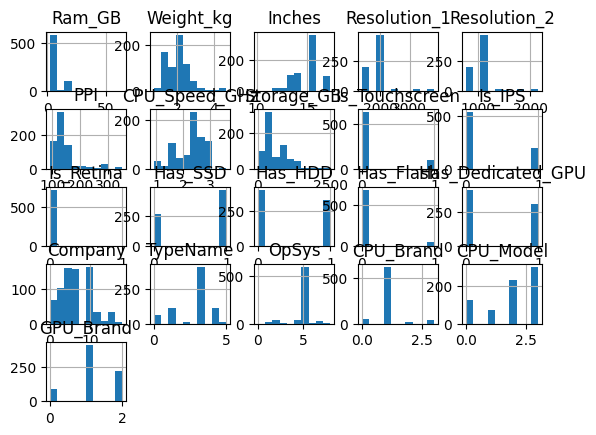

In [31]:
X_train.hist()

<Axes: >

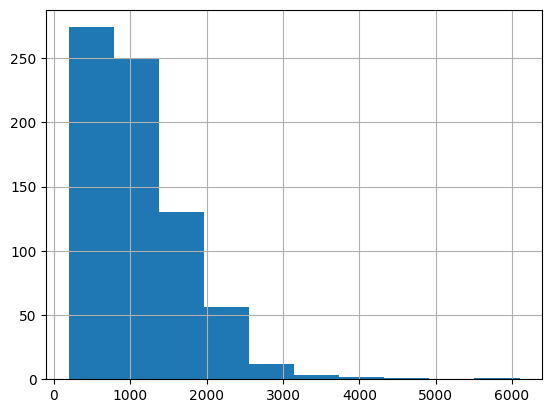

In [82]:
y_train.hist()

-----------------------------------------------------------------------------------------------------------------

## 4. Modelado

### 4.1 Baseline de modelos


In [73]:
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

In [32]:

rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

In [33]:
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=5, 
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [200, 500]},
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'),
             verbose=1)

In [34]:
print("Best RMSE:", -grid_search.best_score_)
print("Best Params:", grid_search.best_params_)


Best RMSE: 285.35962316366
Best Params: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [35]:
y_pred = grid_search.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {test_rmse}")

Test RMSE: 308.0389584911295


In [36]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': grid_search.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
          feature  importance
0          Ram_GB    0.194062
1       Weight_kg    0.130787
19      CPU_Model    0.102491
6   CPU_Speed_GHz    0.086446
4    Resolution_2    0.074931
5             PPI    0.070452
16       TypeName    0.058437
3    Resolution_1    0.057966
11        Has_SSD    0.037633
7      Storage_GB    0.037202


### 4.2 Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de ``RMSE``.

### 4.3 Optimización (up to you 🫰🏻)

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

## 1. Carga los datos de `test.csv` para predecir.


In [37]:
X_pred = pd.read_csv("./data/test.csv", index_col="laptop_ID")
X_pred.name = None

In [38]:
X_pred_processed = feature_engineering(X_pred, is_training=False)

In [41]:
for col in cat_features:
    X_pred_processed[col] = X_pred_processed[col].fillna("Unknown")

X_pred_num = X_pred_processed[features_num].fillna(0)
X_pred_cat = X_pred_processed[cat_features]

 ## 2. Replicar el procesado para ``test.csv``

In [43]:
X_pred_cat_encoded = X_pred_cat.copy()
for col in cat_features:
    # Handle unseen categories
    X_pred_cat_encoded[col] = X_pred_cat[col].astype(str).apply(
        lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1
    )

In [44]:
X_pred_final = pd.concat([X_pred_num, X_pred_cat_encoded], axis=1)

In [45]:
predictions_submit = grid_search.predict(X_pred_final)

In [46]:
print(f"Predictions shape: {predictions_submit.shape}")
print(f"Sample predictions: {predictions_submit[:5]}")

Predictions shape: (391,)
Sample predictions: [1276.89103333  289.22945     400.83595     961.6169      840.05005   ]


In [47]:

predictions_submit

array([1276.89103333,  289.22945   ,  400.83595   ,  961.6169    ,
        840.05005   ,  507.89931667,  785.86235   , 1023.40975   ,
       1338.70265   ,  376.95298333, 2330.911835  , 1326.55835   ,
        505.3918    , 1555.8735    ,  752.37455   ,  793.35012917,
       1770.3435    , 1444.379     , 1705.8774    ,  711.22675   ,
       1391.4754    ,  310.33595   ,  651.37715   , 1161.7268    ,
        482.2392    ,  748.90735   ,  510.9603    ,  804.64905   ,
       2573.06688333, 1072.40065   , 2158.298325  ,  435.33175   ,
        702.3297    , 2924.51143333, 1881.77735   , 1958.3547904 ,
        662.48255   , 1227.64046667,  936.9378    , 1557.9715    ,
        657.47326667,  803.3452    ,  544.65205   , 1231.99775   ,
       1323.08099048, 1083.8282    , 1060.67715   ,  585.0639    ,
        803.25625833,  437.26395   , 1759.2938    ,  795.55291833,
       1179.07861667,  638.85335   , 1942.98245   , 1824.0617    ,
        728.81941667,  982.94195833,  950.43575   ,  647.26885

**¡OJO! ¿Por qué me da error?** 

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [ ]:
# ¿Qué opináis?
# ¿Sí, no?

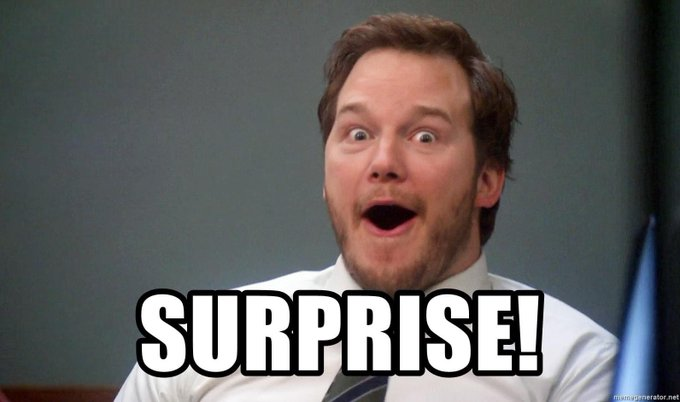

## 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [48]:
sample = pd.read_csv("data/sample_submission.csv")

In [49]:
sample.head()

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6


In [41]:
sample.shape

(391, 2)

## 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [50]:
#¿Cómo creamos la submission?
submission = pd.DataFrame(
    { 
"laptop_ID": X_pred.index,
"Price_in_euros" : predictions_submit})

In [51]:
submission.head()

,laptop_ID,Price_in_euros
0,209,1276.891033
1,1281,289.229450
2,1168,400.835950
3,1231,961.616900
4,1020,840.050050


In [52]:
submission.shape

(391, 2)

## 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [53]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                df_to_submit.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")

In [54]:
chequeador(submission)

You're ready to submit!
